# Energy self-shielding of resonances

Please indicate your name below, since you will need to submit this notebook.

Don't forget to save your progress during the datalab to avoid any loss due to crashes.

In [ ]:
name='Alexander Hedene'

When we looked at group-wise cross sections we have used a simplified neutron spectrum to weight the cross sections with: Maxwellien at thermal energies, 1/E at epithermal energies, and Watt-spectrum at fast energies. We have however ignored the fact that the resonances influence the spectrum. The intention of this datalab is to remedy that and implement methods which are suitable to take into account the impact of resonances on the spectrum. The reader is adviced to review Chapter 8 of [Nuclear Reactor Analysis from Duderstadt and Hamilton](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/89079/1976_Nuclear_Reactor_Analysis.pdf) before this datalab, with a special attention on resonance escape probabilities and resonance integrals. In the following we will just highlight and further elaborate on certain parts of it.

In the following we assume that neutrons slow down in an infinite homogeneous medium: a mixture of resonant nuclei (eg. U-238) and non-resonant, moderator nuclei (eg. H-1 and O-16 of water). The absorber is denoted with "A" whereas the moderator is denoted with "M". We assume that the moderator has a constant scattering cross section at the energies of the resonances of the absorber, and a negligible absorption cross section. The reader is encouraged to look up the cross sections to justify these approximations.

It can be assumed that the practical with of the resonances, $\Gamma_p$ is much smaller than the average energy lost in a collision with the nuclei of the moderator (see p342 of D&H for more detail). This is generally true for the resonances of interest for reactor applications.

However, we need to make a further approximation in regard of the resonance width compared to average  energy lost. Here we will apply the Narrow Resonance approximation, which assumes that the resonance width is also small compared to the average energy lost in collisions with absorber nuclei. In this case the flux in the slowing down energy region can be assumed to be

$$\phi_{NR}(E)\propto \frac{1}{\Sigma_t(E)E}$$

where the total cross section based on our previous discussions is the sum of the total cross section of the absorber and and the constant scattering cross section of the moderator.

$$\Sigma_t(E)=\Sigma_a^A(E)+\Sigma_s^A(E)+\Sigma_s^M$$

One can see that in case the macroscopic scattering cross section of the moderator is much larger than the total cross section of the absorber, the energy dependence of the absorber's total cross section will not have a significant influence, thus the flux will behave as 1/E. This is called infinite dilution (ie. the absorber nuclei is infinitely diluted in the moderator), and you might recall that we mentioned this term in the previous datalab on group cross sections. At this point, unfortunately the D&H book does not introduce an important concept: the [dilution or background cross section](https://t2.lanl.gov/nis/njoy/grou04.html) to represent all other the other isotopes (ie. not the resonant) a constant:

$$\sigma_d=\frac{\Sigma_s^M}{N^A}$$

which is a measure of how diluted the number of resonant atoms ($N^A$) is in the mixture with moderator atoms. One can see that this value has barn units, which is the reason it is considered to be a cross section. With that

$$\phi_{NR}(E)\propto \frac{1}{(\sigma_t(E)+\sigma_d)E}$$

This scheme is sometimes referred to as the Bondarenko method in the literature. According to  the [NJOY16 manual](https://raw.githubusercontent.com/njoy/NJOY2016-manual/master/njoy16.pdf) for uranium-dioxide fuel pins the typical background cross sections are within the range 20 to 50 barns.


## The cross section to collapse

We are going to use the point-wise cross sections previously reconstructed with the SLBW formalism from the resonance parameters for U-238.

Let's read this data! Note, the file name is not necessarily the same, what you gave to your file in order to make sure that a file is available. Also, note that in fact we have reconstructed the capture cross section of U-238, however considering that the fission cross section of U-238 in the energy region of interest is several orders of magnitude lower than the capture cross section, we can safely assume that the absorption cross section equals the capture cross section only.

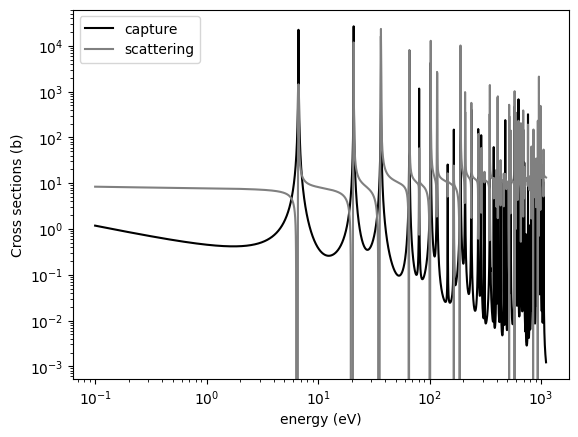

In [5]:
import numpy as np
import matplotlib.pyplot as plt

E, sigma_ar, sigma_sr = np.loadtxt('data/U238reconstructed.dat').transpose()

plt.figure()
plt.loglog(E, sigma_ar,'k',label='capture')
plt.loglog(E, sigma_sr,'gray',label='scattering')
plt.legend()
plt.xlabel('energy (eV)')
plt.ylabel('Cross sections (b)')            
plt.show()

## Group structure and collapsing

We are going to use the same LANL 187-group stucture as earlier, and we are going to use the same method to weight the cross sections. In fact, the function `groupCollapse()` wraps the code we have used earlier. Execute the code cell below.

In [6]:
ind,elow,ehigh=np.loadtxt('data/lanl187.txt').transpose()

def groupCollapse(elow,ehigh,exs,xs,spectrum):
    """Simple function to weight a cross section with a spectrum,
    
    Parameters
    ----------
    elow : list of float
        List of energy bin lower boundaries
    ehigh : list of float
        List of energy bin higher boundaries
    exs : list of float
        List of energy values where the point-wise cross sections and the spectrum is given
    xs : list of float
        Point-wise cross section at energies given by exs
    spectrum : list of float
        Neutron spectrum at energies given by exs
        
    Return
    ------
    grpxs : list of float
        Group-wise cross section. Number of groups is determined by elow and ehigh.
    """
    grpxs=[]
    for el,eh in zip(elow,ehigh):
        Egrid=np.linspace(el,eh,1000)                 #divide the energy group into 1000 values      
        Phigrid=np.interp(Egrid,exs,spectrum)         #evaluate the spectrum at these values
        XSgrid=np.interp(Egrid,exs,xs)                #determine the point-wise xs at these values
        grpxs.append(np.trapz(XSgrid*Phigrid,Egrid)/np.trapz(Phigrid,Egrid))
    return grpxs

## The narrow resonance model

Let us now implement the narrow resonance model. Complete the code cell below to define the function `narrowResonance()`.

Also visualize the spectrum for three values of back ground cross sections (1, 100 and $10^{10}$ barns, we will refer to the latter as infinite dilution).

In [ ]:
def narrowResonance(E, sigma_ar, sigma_sr, sigma_d):
    """Function to calculate the spectrum according to the Narrow Resonance model.
    
    Parameters
    ----------
    E : list of float
        List of energy values where the point-wise cross sections are given and the
        spectrum is to be evaluated
    sigma_ar : list of float
        Point-wise absorption cross section of the resonant nuclide at energies given by E
    sigma_sr : list of float
        Point-wise scattering cross section of the resonant nuclide at energies given by E
    sigma_d : float
        Background cross section
    """
    sigma_t = sigma_ar + sigma_sr
    phi = 1/((sigma_t + sigma_d)*E)
    return phi/phi[0] #Normalize so flux at various dilution is readily comparable

plt.figure()
plt.loglog(E,narrowResonance(E,sigma_ar,sigma_sr,1),'k',label='$\sigma_d=1$')
plt.loglog(E,narrowResonance(E,sigma_ar,sigma_sr,100),'m',label='$\sigma_d=100$')
plt.loglog(E,narrowResonance(E,sigma_ar,sigma_sr,1e10),'b',label='$\sigma_d=\infty$')
plt.xlabel('Energy (eV)')
plt.ylabel('Normalized Flux (eV$^{-1}$)')
plt.legend()
plt.show()

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
C:\Users\alexh\AppData\Local\Temp\ipykernel_15732\2093090252.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.loglog(E,narrowResonance(E,sigma_ar,sigma_sr,1),'k',label='$\sigma_d=1$')
C:\Users\alexh\AppData\Local\Temp\ipykernel_15732\2093090252.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.loglog(E,narrowResonance(E,sigma_ar,sigma_sr,100),'m',label='$\sigma_d=100$')
C:\Users\alexh\AppData\Local\Temp\ipykernel_15732\2093090252.py:22: SyntaxWarning: invalid escape sequence '\s'
  plt.loglog(E,narrowResonance(E,sigma_ar,sigma_sr,1e10),'b',label='$\sigma_d=\infty$')
C:\Users\alexh\AppData\Local\Temp\ipykernel_15732\2093090252.py:20: SyntaxWarning: invalid escape sequence

NameError: name 'phi' is not defined

<Figure size 640x480 with 0 Axes>

Conclude your finding, what happens as the dilution goes towards infinity?

## Creating self-shielded group cross sections

In the following we will weight the point-wise cross section with the flux at various dilutions. The resulting cross-sections are often referred to as self-shielded cross sections, since the weighting takes into account the energy self-shielding effects.


In [ ]:
sigma_d = np.logspace(0,10,11)

sigma_g = {} #dictionary to store group cross sections at various dilution

plt.figure()
plt.loglog(E,sigma_ar,label='point-wise')
plt.xlim(5,50)
plt.ylim(0.1,8000)
for sd in sigma_d:
    sigma_g[sd]=#complete the line
    if sd in [1,10,100,10000,1e10]:
        plt.step(ehigh,sigma_g[sd],label=r'$\sigma_d=10^{%d} b$'%(np.log10(sd)))
plt.xlabel('Energy (eV)')
plt.ylabel('Cross sections (barns)')
plt.legend()
plt.show()

Notice, that at certain energies the dilution does not have an impact on the group constants, however at the resonances, using infinitely dilute cross sections results in much higher cross sections.

In order to quantify the impact of self-shielding, we can evaluate the self-shielding factor $$SSF=\sigma_g(E,d)/\sigma_g(E,d=\infty)$$ which gives the ratio between the self-shielded cross section for a given group at a given dilution and the cross section at infinite dilution. Let us take a look at the group 6.47595 - 6.868 eV, since this is the group which accommodates a significant resonance at 6.67 eV.

In [ ]:
grp=58 # group index of interest
inf_dilute=sigma_d[-1]
SSF = []
for sd in sigma_d:
      SSF.append(sigma_g[sd][grp] / sigma_g[inf_dilute][grp])
plt.figure()
plt.semilogx(sigma_d,SSF,'ko')
plt.xlabel('Dilution')
plt.ylabel('SSF')
plt.show()

Alternatively, we can visualize the self-shielding factor for all the groups for a given dilution, similarly as given at the [UKAEA's page](https://fispact.ukaea.uk/development/self-shielding/).

In [ ]:
plt.figure()
plt.step(ehigh,np.array(sigma_g[100])/np.array(sigma_g[inf_dilute]),'k')
plt.xscale('log')
plt.xlim(1e0,1e4)
plt.ylabel('SSF')
plt.xlabel('Energy (eV)')
plt.show()

## Conclusions and comments

Building on our previous work from reconstructing and collapsing cross sections we have generated self-shielded multigroup constant. In practice, of course the Doppler-broadening step is typically performed before self-shielding the cross sections, and now we have discussed Doppler-broadening only separately.

It must be mentioned that our approximation in this datalab was to consider an infinite homogeneous mixture, whereas in reality the geometry has an influence on the multi-group cross sections (eg. due to spatial self-shielding). This however is somewhat outside of the discussions on nuclear data processing, and involves reactor physics methods, which is not a subject of this module.

Finally, it has to be mentioned, that although the D&H book mentions that transport and Monte Carlo methods are computationally too expensive to perform group constant generation, at the present it is not true anymore, and Monte Carlo methods are used more and more frequently to generate the group constants, in this way both spatial and energy self-shielding effects can be taken into account in a rather intuitive manner.

# Acknowledgment

The datalab was inspired by the scripts available at [Jeremy A. Roberts' github page](https://github.com/robertsj/applied_reactor_physics). 